## Test Against Analytic Solution

In [1]:
from POSEIDON.core import create_star
from POSEIDON.constants import R_Sun
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J, M_J
from POSEIDON.core import define_model
from POSEIDON.core import make_atmosphere
from POSEIDON.core import read_opacities, wl_grid_constant_R
from POSEIDON.absorption import Rayleigh_cross_section
import scipy.constants as sc
from scipy.special import expn
import numpy as np

#***** Define stellar properties *****#

R_s = R_Sun      # Stellar radius (m)
T_s = 5000.0     # Stellar effective temperature (K)
Met_s = 0.0      # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.0    # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'Example Planet'  # Planet name used for plots, output files etc.

R_p = R_J         # Planetary radius (m)
M_p = M_J         # Planet mass (kg)
T_eq = 1000.0     # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, T_eq = T_eq)

#***** Define model *****#

model_name = 'Only_Rayleigh'  # Model name used for plots, output files etc.

bulk_species = ['H2']      # Only H2
param_species = []         # No other gases for this test

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm')

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 100.0   # Reference pressure (bar)
R_p_ref = R_p   # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([T_eq])         
log_X_params = np.array([])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params,
                             constant_gravity = True)

#***** Wavelength grid *****#
 
wl_min = 0.2      # Minimum wavelength (um)
wl_max = 10.0     # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 900
T_fine_max = 1100
T_fine_step = 10

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0
log_P_fine_max = 2.0
log_P_fine_step = 0.2

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine,
                      testing = True)

# Remove H2-H2 CIA for this test
opac['CIA_stored'] *= 0.0

#***** Analytic calculation *****#

# Using the analytic expression for an atmosphere with constant scale height,
# constant cross section with altitude, and H/Rp << 1

# Load H2 Rayleigh scattering cross section from POSEIDON 
sigma_H2, _ = Rayleigh_cross_section(wl, 'H2')

# Load mean molecular mass from POSEIDON
mu = atmosphere['mu'][0,0,0]

# Calculate required quantities for analytic expression
g = sc.G * M_p / R_p**2
H = sc.k * T_eq / (mu * g)
gamma = 0.5772156649
kappa = sigma_H2 / mu

# Surface pressure and radius
P_surface = 1e7                            # 100 bar in Pa
R_surface = atmosphere['r_low'][0,0,0]     # Bottom of model atmosphere

# Calculate equivalent surface optical depth
tau_surface = P_surface/g * np.sqrt(2*np.pi*R_surface/H) * kappa

# Calculate effective planet radius as function of wavelength
analytic_R = R_surface + H*(gamma + np.log(tau_surface) + expn(1, tau_surface))

# Convert units to transit depth
spectrum_analytic = analytic_R**2 / R_s**2


Reading in cross sections in opacity sampling mode...
H2-H2 done
Opacity pre-interpolation complete.


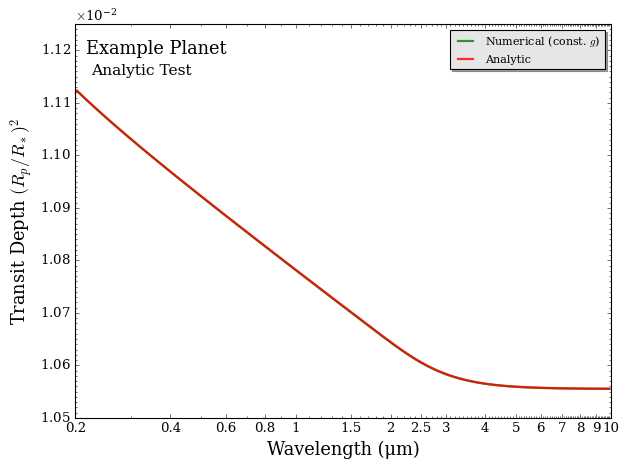

In [2]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate our transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                                    spectrum_type = 'transmission')

spectra = []   # Empty plot collection

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = spectra)
spectra = plot_collection(spectrum_analytic, wl, collection = spectra)

# Produce figure and save to file
fig = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                   plt_label = 'Analytic Test',
                   spectra_labels = ['Numerical (const. $g$)', 'Analytic'],
                   y_max = 1.125e-2)


Check magnitude of difference between numerical and analytical solution

In [3]:
ratios = spectrum_analytic / spectrum
relative_diffs = np.abs(ratios - 1)

print('Max relative diff = ' + str(np.max(relative_diffs*1e2)) + ' %')

diff = np.abs(spectrum_analytic - spectrum)

print('Max diff = ' + str(np.max(diff*1e6)) + ' ppm')
print('Mean diff = ' + str(np.mean(diff*1e6)) + ' ppm')

Max relative diff = 0.009053765428967964 %
Max diff = 0.9638284875299746 ppm
Mean diff = 0.5878634098462163 ppm


## Test Retrieval

In [4]:
from POSEIDON.constants import R_Sun, R_J
from POSEIDON.core import create_star, create_planet, define_model, \
                          make_atmosphere, read_opacities, wl_grid_constant_R, \
                          compute_spectrum, load_data, set_priors
from POSEIDON.instrument import generate_syn_data_from_user
from POSEIDON.visuals import plot_spectra, plot_spectra_retrieved
from POSEIDON.utility import plot_collection, read_retrieved_spectrum
from POSEIDON.retrieval import run_retrieval
from POSEIDON.corner import generate_cornerplot
import scipy.constants as sc
import pymultinest
import numpy as np
import os

#***** Define stellar properties *****#

R_s = 1.46*R_Sun      # Stellar radius (m)
T_s = 6776.0          # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-121b'  # Planet name used for plots, output files etc.

R_p = 1.753*R_J      # Planetary radius (m)
log_g_p = 2.97       # Gravitational field of planet (cgs)
T_eq = 2450          # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, log_g = log_g_p, T_eq = T_eq)

#***** Model wavelength grid *****#

wl_min = 0.4    # Minimum wavelength (um)
wl_max = 1.8    # Maximum wavelength (um)
R = 1000   # We can get away with R = 1k for this test, since we only have continuum opacity

# We need to provide a model wavelength grid to initialise instrument properties
wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define model *****#

model_name = 'H-_retrieval_test'

bulk_species = ['H2', 'He']
param_species = ['H-']

# Create the model object
model = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm')

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p   # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([T_eq])         
log_X_params = np.array([-9.0])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 800
T_fine_max = 3000
T_fine_step = 10

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0
log_P_fine_max = 2.0
log_P_fine_step = 0.2

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Read cross sections
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine,
                      testing = True)

# Generate transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                                    spectrum_type = 'transmission')

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H-bf done
Opacity pre-interpolation complete.


Plot spectrum

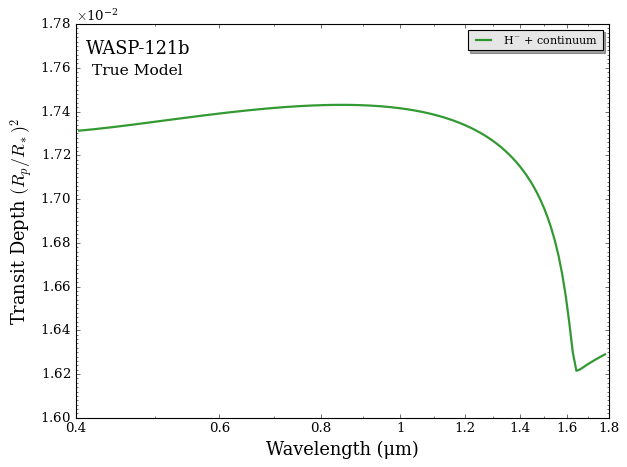

In [5]:
spectra = []   # Empty plot collection

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = spectra)

# Produce figure and save to file
fig = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                   plt_label = 'True Model',
                   spectra_labels = ['H$^{-}$ + continuum'],
                   y_min = 1.60e-2, y_max = 1.78e-2)

Generate simulated data

In [6]:
data_dir = './data/WASP-121b'

# Generate synthetic data
generate_syn_data_from_user(planet, wl, spectrum, data_dir, instrument = 'dummy',
                            R_data = 30, err_data = 50, wl_start = 0.45, 
                            wl_end = 1.7, Gauss_scatter = False)

# Load synthetic data file
datasets = ['WASP-121b_SYNTHETIC_dummy.dat']
instruments = ['dummy']

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl, wl_unit = 'micron',
                 bin_width = 'half', spectrum_unit = 'transit_depth', skiprows = None)

Creating synthetic data
POSEIDON does not currently have an instrument transmission function for dummy, so a box function will be used.
POSEIDON does not currently have an instrument transmission function for dummy, so a box function will be used.


Plot the spectrum with data added

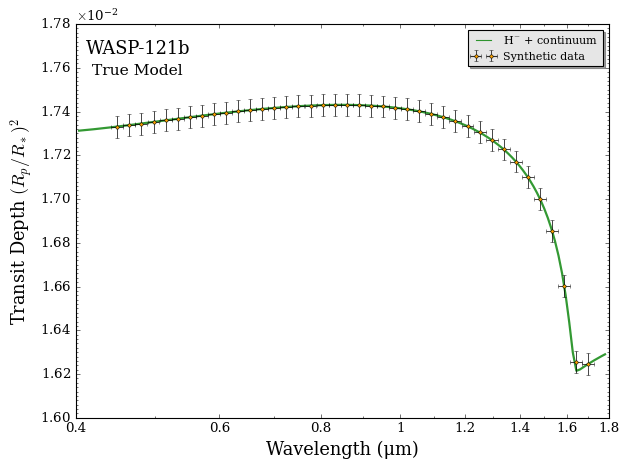

In [7]:
# Produce figure and save to file
fig = plot_spectra(spectra, planet, data_properties = data, R_to_bin = 100, 
                   show_data = True, plot_full_res = False,
                   plt_label = 'True Model',
                   spectra_labels = ['H$^{-}$ + continuum'],
                   data_labels = ['Synthetic data'],
                   y_min = 1.60e-2, y_max = 1.78e-2)

Run retrieval

In [8]:
#***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_H-'] = 'uniform'

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [800, 3000]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_H2O'] = [-14, -2]

# Create prior object for retrieval
priors = set_priors(planet, star, model, data, prior_types, prior_ranges)

#***** Run atmospheric retrieval *****#

run_retrieval(planet, star, model, opac, data, priors, wl, P, P_ref, R = R, 
                spectrum_type = 'transmission', sampling_algorithm = 'MultiNest', 
                N_live = 400, verbose = True)

POSEIDON now running 'H-_retrieval_test'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.991189
Replacements:                                450
Total Samples:                               454
Nested Sampling ln(Z):            -263849.780732
Acceptance Rate:                        0.970874
Replacements:                                500
Total Samples:                               515
Nested Sampling ln(Z):            -167836.497817
Acceptance Rate:                        0.951557
Replacements:                                550
Total Samples:                               578
Nested Sampling ln(Z):            -130688.814247
Acceptance Rate:                        0.911854
Re

Plot retrieval results

Generating corner plot ...


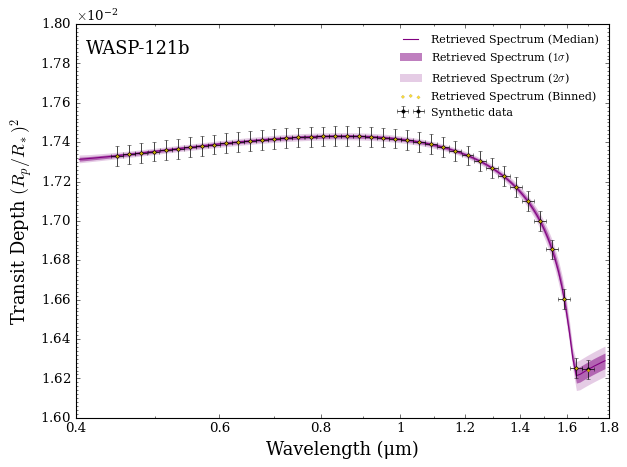

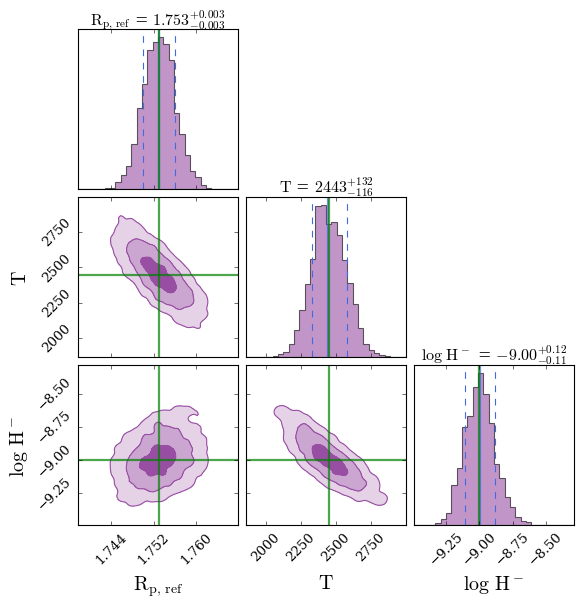

In [9]:
#***** Plot retrieved transmission spectrum *****#

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data, R_to_bin = 100,
                                  data_labels = ['Synthetic data'],
                                  plt_label = 'Continuum Retrieval Test',
                                  data_colour_list = ['black'],
                                  y_min = 1.60e-2, y_max = 1.80e-2)

#***** Make corner plot *****#

true_vals = [1.753, T_eq, log_X_params[0]]

fig_corner = generate_cornerplot(planet, model, true_vals = true_vals)

Check retrieval results match true values

In [10]:
#***** Read MultiNest retrieval results *****#

# Change directory into MultiNest result file folder
output_dir = './POSEIDON_output/' + planet_name + '/retrievals/'
os.chdir(output_dir + 'MultiNest_raw/')

n_params = len(model['param_names'])

# Run PyMultiNest analyser to extract posterior samples and model evidence
analyzer = pymultinest.Analyzer(n_params, verbose = False,
                                outputfiles_basename = model_name + '-')

stats = analyzer.get_stats()

# Load retrieved median values for the planet radius, temperature, and log(H2O)
for i in range(n_params):

    parameter = model['param_names'][i]
    true_median = true_vals[i]

    m = stats['marginals'][i]
    retrieved_median = m['median']

    # Check relative difference between solutions < 0.5%
    relative_diff = np.abs((retrieved_median - true_median)/true_median)

    print('Relative diff for ' + parameter + ' = ' + 
            str(round(np.max(relative_diff*1e2),3)) + ' %')

    assert relative_diff < 0.005

os.chdir('../../../../')

print("Retrieval test passed!")

Relative diff for R_p_ref = 0.001 %
Relative diff for T = 0.298 %
Relative diff for log_H- = 0.012 %
Retrieval test passed!
